# 16-8. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

In [1]:
import os
data_path = './data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


### 이미지들이 어떻게 생겼는지 확인하기

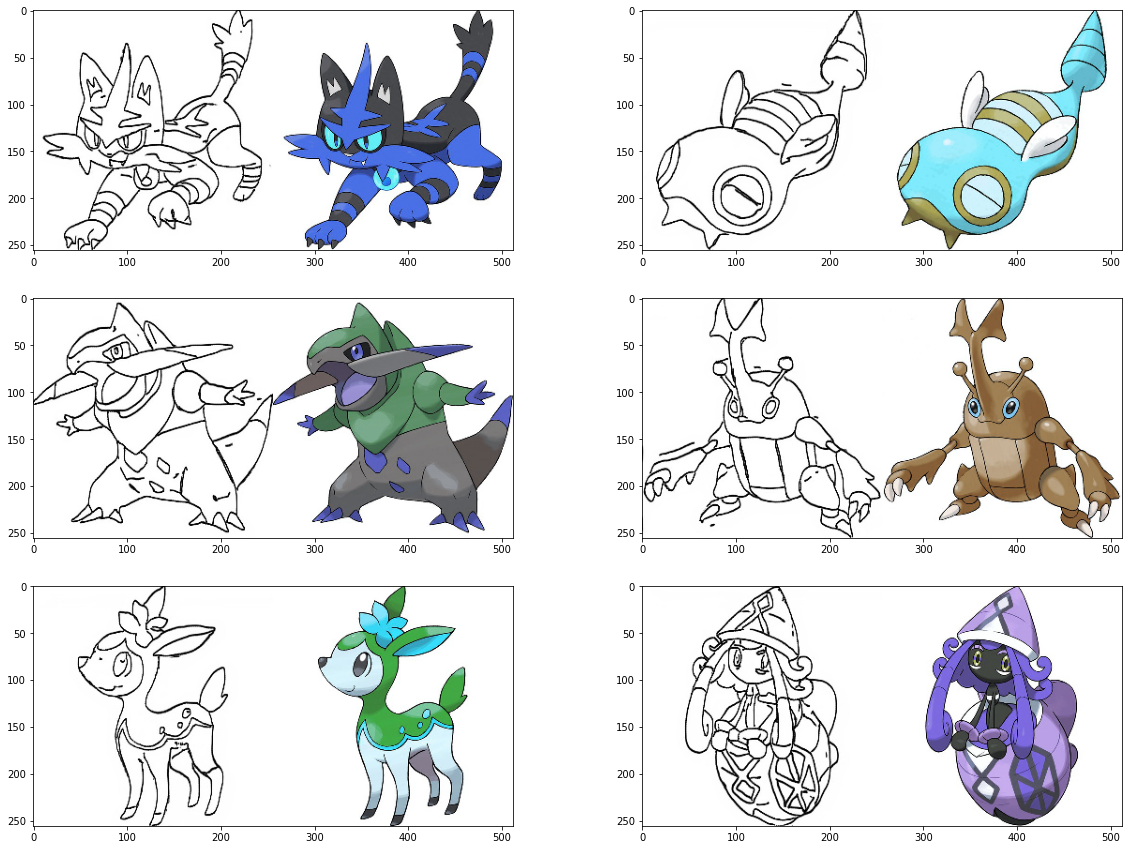

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1,7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f,cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f,cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


### 두개로 붙어있는 이미지를 (256,256,3), (256,256,3)으로 나누기

2023-02-13 12:50:31.612442: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


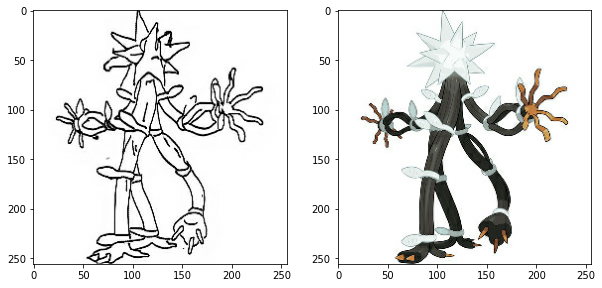

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x,tf.float32)
    return (x/127.5)-1

def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img,3)
    
    w = tf.shape(img)[1] //2 #width 256으로
    sketch = img[:,:w,:]
    sketch = tf.cast(sketch,tf.float32)
    colored = img[:,w:,:]
    colored = tf.cast(colored,tf.float32)
    return normalize(sketch),normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch,colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### 데이터 개수가 적으므로 augmentation 방법 적용

In [9]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


2023-02-13 14:29:04.004049: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


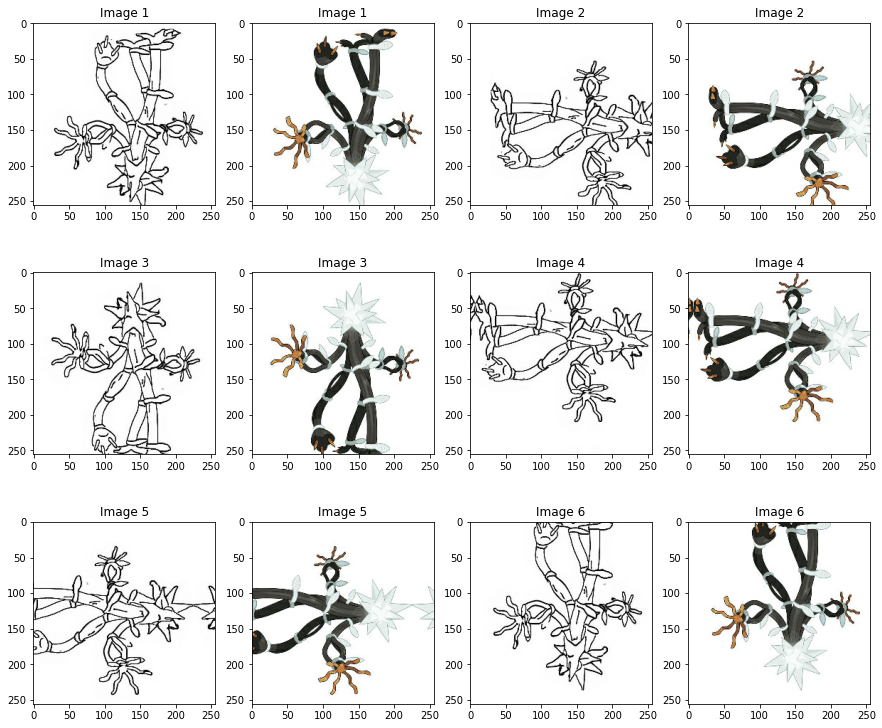

In [10]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

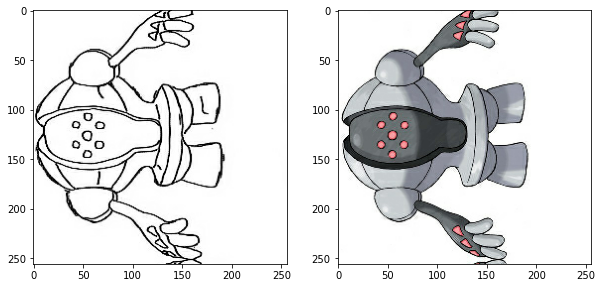

In [13]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch,colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1) * 127.5, (sample[0][1]+1) * 127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 16-9. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

In [18]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [19]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [20]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_6 (EncodeBlock) (None, 4, 4, 512)         419635

In [24]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [25]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [26]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block_7 (DecodeBlock) (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_8 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_9 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_10 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_11 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_12 (DecodeBlock (None, 64, 64, 128)       5248

In [27]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self,input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs,self.call(inputs)).summary()
    
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_2 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_2 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


# 16-10. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

In [29]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator,self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i==0:
                self.encode_blocks.append(EncodeBlock(f,use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i , f in enumerate(decode_filters):
            if i<3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f,dropout=False))
        self.last_conv = layers.Conv2DTranspose(3,4,2,'same',use_bias=False)
        
    def call(self,x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        features = features[:-1]
        
        for block,feat in zip(self.decode_blocks,features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x,feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self,input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs,self.call(inputs)).summary()

In [30]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_17[0][0]            
__________________________________________________________________________________________________
encode_block_19 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_18[0][0]            
____________________________________________________________________________________________

# 16-11. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

In [36]:
class DiscBlock(layers.Layer):
    def __init__(self,n_filters,stride=2,custom_pad=False,use_bn=True,act=True):
        super(DiscBlock,self).__init__()
        self.custom_pad = custom_pad #무엇
        self.use_bn = use_bn #batchnormalization 사용 여부 조절
        self.act = act #무엇
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters,4,stride,'valid',use_bias=False)
        else: #사용자 정의 패딩이 없으면 그냥 패딩 없이 
            self.conv = layers.Conv2D(n_filters,4,stride,"same",use_bias=False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self,x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
        
        if self.act:
            x = self.lrelu(x)
        
        return x
        
print("completed!")       

completed!


In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64,4,1,'valid',use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs,out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_55 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [37]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64,stride=2,custom_pad=False,use_bn=False,act=True)
        self.block3 = DiscBlock(n_filters=128,stride=2,custom_pad=False,use_bn=True,act=True)
        self.block4 = DiscBlock(n_filters=256,stride=2,custom_pad=False,use_bn=True,act=True)
        self.block5 = DiscBlock(n_filters=512,stride=1,custom_pad=True,use_bn=True,act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1,custom_pad=True,use_bn=False,act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        
    def call(self,x,y):
        out = self.block1([x,y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self,x_shape=(256,256,3),y_shape=(256,256,3)):
        x,y = Input(x_shape),Input(y_shape)
        return Model((x,y),self.call(x,y)).summary()

In [38]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block_1 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_8[0][0]        

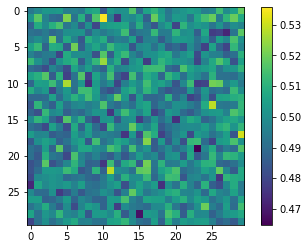

In [39]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 16-12. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

In [40]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output,real_output,fake_disc):
    l1_loss = mae(real_output,fake_output)
    gene_loss = bce(tf.ones_like(fake_output),fake_output)
    return gene_loss,l1_loss

def get_disc_loss(fake_disc,real_disc):
    return bce(tf.zeros_like(fake_disc),fake_disc) + bce(tf.ones_like(real_disc),real_disc)

print("complete!")

complete!


In [43]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4,beta_1=.5,beta_2=.999)
disc_opt = optimizers.Adam(2e-4,beta_1=.5,beta_2=.999)

print("ok!")

ok!


In [42]:
@tf.function
def train_step(sketch,real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        #Generator 예측
        fake_colored = generator(sketch,training=True)
        
        #Discriminator 예측
        fake_disc = discriminator(sketch,fake_colored,training=True)
        real_disc = discriminator(sketch,real_colored,training=True)
        
        #generator 손실 계산
        gene_loss,l1_loss = get_gene_loss(fake_colored,real_colored,fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        
        #discriminator 손실 계산
        
        

✅
